In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('prepared_data_mercury_concentrations.csv', index_col='id')
df = df[df['mea_ug_kg_orig'] >= 0]

In [3]:
df.head()

,lat,lon,mea_ug_kg_orig
id,,,
75,43.109118,3.693405,330.0
76,43.109118,3.693405,350.0
80,42.780537,4.352197,170.0
81,42.780537,4.352197,260.0
162,41.883963,15.439161,180.0


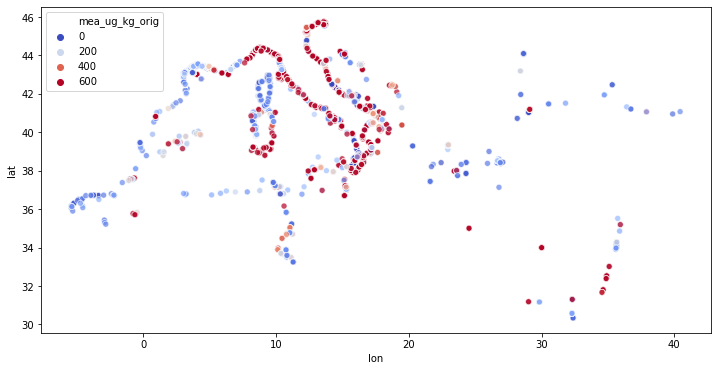

In [4]:
plt.figure(figsize=(12 ,6))
# Norm from EPA guidance
epa_norm = 460

hue_norm_custom = (0, epa_norm)
sns.scatterplot(x='lon', y='lat', hue='mea_ug_kg_orig',
                hue_norm=hue_norm_custom,
                palette='coolwarm', alpha=.7,
                data=df)
plt.show()

In [5]:
# Not known points!

In [6]:
gdf = gpd.read_file('medi_coastline.shp')

In [7]:
gdf.head()

,id,geometry
0,1204,MULTIPOINT (13.07189 45.77755)
1,1205,MULTIPOINT (13.12189 45.77755)
2,1206,MULTIPOINT (13.17189 45.77755)
3,1207,MULTIPOINT (13.22189 45.77755)
4,1208,MULTIPOINT (13.27189 45.77755)


In [8]:
print(gdf.crs)

epsg:4326


In [9]:
def set_coordinate(point_geometry, coordinate: str):
    """
    Function returns coordinate x or y from multipoint geometry in geodataframe.
    :param point_geometry: MultiPoint or Point geometry,
    :param coordinate: x (longitude) or y (latitude).
    """
    
    if coordinate == 'x':
        try:
            x_coo = point_geometry.x
            return x_coo
        except AttributeError:
            x_coo = point_geometry[0].x
            return x_coo
    elif coordinate == 'y':
        try:
            y_coo = point_geometry.y
            return y_coo
        except AttributeError:
            y_coo = point_geometry[0].y
            return y_coo
    else:
        raise KeyError('Available coordinates: "x" for longitude or "y" for latitude')

In [10]:
gdf['lat'] = gdf['geometry'].apply(set_coordinate, args=('y'))
gdf['lon'] = gdf['geometry'].apply(set_coordinate, args=('x'))

In [11]:
gdf.head()

,id,geometry,lat,lon
0,1204,MULTIPOINT (13.07189 45.77755),45.777552,13.071886
1,1205,MULTIPOINT (13.12189 45.77755),45.777552,13.121886
2,1206,MULTIPOINT (13.17189 45.77755),45.777552,13.171886
3,1207,MULTIPOINT (13.22189 45.77755),45.777552,13.221886
4,1208,MULTIPOINT (13.27189 45.77755),45.777552,13.271886


In [12]:
def calculate_distances(all_points, unknown_point):
    # Calculate distances
    d_lat = (all_points[:, 0] - unknown_point[0])**2
    d_lon = (all_points[:, 1] - unknown_point[1])**2
    dists = np.sqrt(d_lon + d_lat)
    return dists
    

def inverse_distance_weighting(unknown_point, points, power, ndist=10):
    """
    Function estimates values in unknown points with with inverse weighted interpolation technique.
    
    INPUT:
    :param unknown_point: lat, lon coordinates of unknown point,
    :param points: (array) list of points [lat, lon, val],
    :param power: (float) constant used to calculate IDW weight -> weight = 1/(distance**power),
    :param ndist: (int) how many closest distances are included in weighting,
    
    OUTPUT:
    :return interpolated_value: (float) interpolated value by IDW method.
    
    Inverse distance weighted interpolation is:
    
    est = SUM(WEIGHTS * KNOWN VALS) / SUM(WEIGHTS)
    and
    WEIGHTS = 1 / (DISTANCE TO UNKNOWN**power)
    
    where:
    power is a constant hyperparameter which tells how much point is influenced by other points. 
    """

    distances = calculate_distances(points, unknown_point)
    points_and_dists = np.c_[points, distances]
    
    # Sort and get only 10 values
    points_and_dists = points_and_dists[points_and_dists[:, -1].argsort()]
    vals_for_idw = points_and_dists[:ndist, :]
    
    # Check if first distance is 0
    if vals_for_idw[0, -1] == 0:
        return vals_for_idw[0, 2]
    else:
        # If its not perform calculations
        weights = 1 / (vals_for_idw[:, -1]**power)
        numerator = weights * vals_for_idw[:, 2]
        interpolated_value = np.sum(numerator) / np.sum(weights)
        return interpolated_value

In [13]:
# Interpolate points

known_points_array = df.to_numpy()
power = 3
nd = 4

In [14]:
gdf['est'] = gdf.apply(lambda col: inverse_distance_weighting(
    [col['lat'], col['lon']],
    known_points_array, power, ndist=nd), axis=1)

In [15]:
gdf.head()

,id,geometry,lat,lon,est
0,1204,MULTIPOINT (13.07189 45.77755),45.777552,13.071886,688.199908
1,1205,MULTIPOINT (13.12189 45.77755),45.777552,13.121886,1757.500000
2,1206,MULTIPOINT (13.17189 45.77755),45.777552,13.171886,1757.500000
3,1207,MULTIPOINT (13.22189 45.77755),45.777552,13.221886,1784.500000
4,1208,MULTIPOINT (13.27189 45.77755),45.777552,13.271886,165.000000


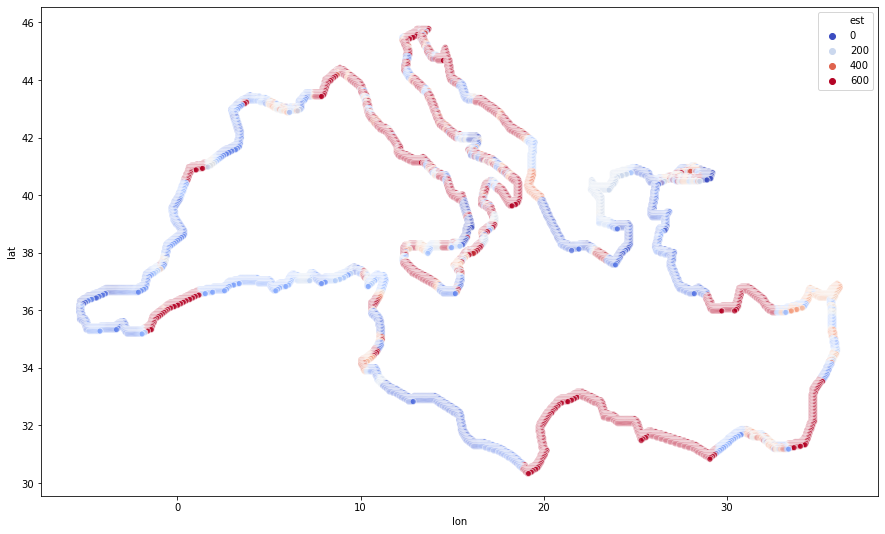

In [16]:
plt.figure(figsize=(15 ,9))
sns.scatterplot(x='lon', y='lat', hue='est', alpha=0.7, palette='coolwarm',
                hue_norm=hue_norm_custom, data=gdf)
plt.show()